# Using data crawling and logistic regression to analyze public sentiment: A case study of Shanghai Disneyland

In [2]:
#The packages of functions 
import requests
import time
import random
import pandas as pd
import numpy as np
import re
import pymysql
from sqlalchemy import create_engine
import jieba
import jieba.analyse
import matplotlib.pyplot as plt

# 1.Using data crawling technology to get search results of Shanghai Disneyland on Weibo


In [33]:
# Search on m.weibo.cn for keywords and open the browser console to get the URL
headers={"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:71.0) Gecko/20100101 Firefox/71.0"}
# Estimated total number of Weibo tweets crawled
total_page=400
# Store Weibo content and user data
mblog = list()
user = list()
# Different Weibo tweets text data are collected based on whether the text is long
long_text_count = 0
source_json =[]
erro=0
for page in range(total_page):
    print('Crawling page:%d/%d'%(page+1,total_page))
    cur_url=url + str(page+1)
    testdata=requests.get(cur_url,headers=headers)
    if testdata.status_code==200:# Ensure the returned data is valid if the connection is successful
        source_json = testdata.json()       
        time.sleep(random.uniform(1,3))# Random time crawl interval, avoid quick crawl trigger anti-crawler
        source_data=source_json['data']
        cards = source_data['cards'] if 'cards' in source_data else []
        for card in cards:
            if 'mblog' in card:
                cur_blog = card['mblog']
                cur_text = ''
                is_long_text = 0
                if cur_blog['isLongText'] == True:
                    cur_text = cur_blog['longText']['longTextContent']
                    is_long_text = 1
                else:
                    cur_text = cur_blog['text']
                verified_reason = cur_blog['user']['verified_reason'] if 'verified_reason' in cur_blog['user'] else None 
                # Record Weibo tweets data
                mblog.append({'mid':cur_blog['mid']
                             ,'raw_text':cur_text
                             ,'isLongText':is_long_text
                             ,'like_count':cur_blog['attitudes_count']
                             ,'comments_count':cur_blog['comments_count']
                             ,'reposts_count':cur_blog['reposts_count']
                             ,'created_at':cur_blog['created_at']
                             ,'source':cur_blog['source']
                             ,'user_id':cur_blog['user']['id']
                             })
                # Record user data
                user.append({'user_id':cur_blog['user']['id']
                            ,'screen_name':cur_blog['user']['screen_name']
                            ,'description':cur_blog['user']['description']
                            ,'follow_count':cur_blog['user']['follow_count']
                            ,'followers_count':cur_blog['user']['followers_count']
                            ,'gender':cur_blog['user']['gender']
                            ,'verified':cur_blog['user']['verified']
                            ,'verified_reason':verified_reason
                            ,'profile_url':cur_blog['user']['profile_url']
                            })
    else:
        # Record number of failed crawls
        erro+=1
        print('erro')
        if erro>15:
            break
print('Crawl finished')
print('共爬取数据条数：',len(mblog))
print('错误数：',erro)

Crawling page:1/400
Crawling page:2/400
Crawling page:3/400
Crawling page:4/400
Crawling page:5/400
Crawling page:6/400
Crawling page:7/400
Crawling page:8/400
Crawling page:9/400
Crawling page:10/400
Crawling page:11/400
Crawling page:12/400
Crawling page:13/400
Crawling page:14/400
Crawling page:15/400
Crawling page:16/400
Crawling page:17/400
Crawling page:18/400
Crawling page:19/400
Crawling page:20/400
Crawling page:21/400
Crawling page:22/400
Crawling page:23/400
Crawling page:24/400
Crawling page:25/400
Crawling page:26/400
Crawling page:27/400
Crawling page:28/400
Crawling page:29/400
Crawling page:30/400
Crawling page:31/400
Crawling page:32/400
Crawling page:33/400
Crawling page:34/400
Crawling page:35/400
Crawling page:36/400
Crawling page:37/400
Crawling page:38/400
Crawling page:39/400
Crawling page:40/400
Crawling page:41/400
Crawling page:42/400
Crawling page:43/400
Crawling page:44/400
erro
Crawling page:45/400
erro
Crawling page:46/400
erro
Crawling page:47/400
erro
Cr

Due to the anti-crawling mechanism, Weibo cannot be crawled after crawling 59 pages. There were 16 consecutive failures after the interruption of crawling, and we finally got 59 pages including 412 related Weibo tweets.

In [34]:
mblog_frame = pd.DataFrame(mblog)
user_frame = pd.DataFrame(user)
# Remove duplicate data
mblog_frame.drop_duplicates(subset=['mid'],inplace=True)
user_frame.drop_duplicates(subset=['user_id'],inplace=True)
# Save data
mblog_frame.to_csv('mblog.csv',index=None,encoding='utf_8_sig')
user_frame.to_csv('users.csv', encoding='utf_8_sig',index=False)

Eliminate Duplicate Data and save data

# 2.Crawling users' information through Weibo# 2.通过微博数据爬取用户信息

In [210]:
# According to the crawled user ID, we can have the accesses to users homepage to obtain the user information
def get_containerid(id):
    """
    obtain containerid
    """
# Get the user ID  
    containerid_url = 'https://m.weibo.cn/api/container/getIndex?type=uid&value='+id    
    containerid = requests.get(containerid_url)
    if containerid.status_code==200:#确保返回数据为连接成功状态下的有效数据
        containerid_json =containerid.json()
        containerid_data = containerid_json['data'] if 'data' in containerid_json else None
        if not containerid_data:
            return None
        tabsInfo = containerid_data['tabsInfo'] if 'tabsInfo'in containerid_data else None  
        if not tabsInfo:
            return None
        tabs = tabsInfo['tabs'] if 'tabs' in tabsInfo else None
        if not tabs:
            return None
        containerid = tabs[0]['containerid'] if 'containerid'in tabs[0] else None
        return containerid
    else:
        return None

# Get the user address
def get_user_location(raw):
    profile_url = raw['profile_url']
    left,right = profile_url.split('?')
    uid =  str(raw['user_id'])
    pre = 'https://m.weibo.cn/api/container/getIndex?'
    mid = '&type=uid&value='
    containerid = get_containerid(uid)
    if not containerid:
        return None
    final_url = pre+right+mid+uid+'&containerid='+containerid
    local = requests.get(final_url)
    if local.status_code==200:
        local_json =local.json()
        data = local_json['data'] if 'data' in local_json else None
        if not data:
            return None
        cards = data['cards'] if 'cards' in data else None
        if not cards:
            return None
        card_group = cards[0]['card_group'] if 'card_group' in cards[0] else None
        if not card_group:
            return None
        location = card_group[0]['item_content'] if 'item_content' in card_group[0] else None
        return location
    else:
        return None
# Get the user's region and save the results to a file
user_frame['location'] = user_frame.apply(get_user_location,axis=1)
user_frame.to_csv('users2.csv',index=None,encoding='utf_8_sig')

Due to the instability of the network, a small range of user data can not be obtained

In [211]:
# Read data
user_frame = pd.read_csv('users2.csv',index_col=None)
# location data processing,saving to the provinces
user_frame['location']=user_frame.location.fillna('其他')
def get_provience(loc):
    location = str(loc)
    location = re.findall(r"^[\u4e00-\u9fff][^' ']*",location)
    if not location:
        return '其他'
    return location[0]
user_frame['location'] = user_frame['location'].apply(get_provience)

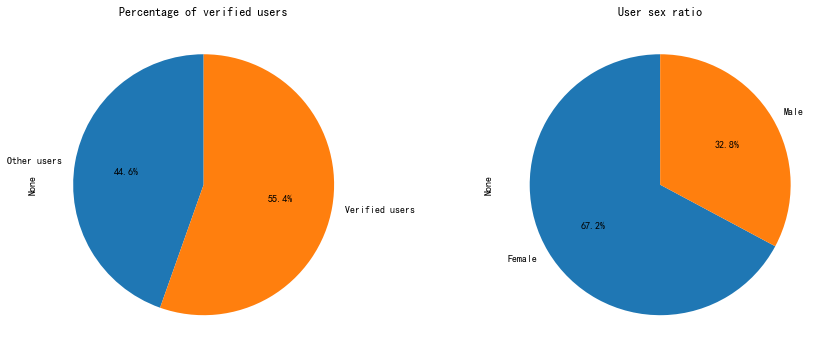

In [244]:
# Percentage of authenticated users
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] # Display Chinese
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
labels = ['Other users','Verified users']
plt.title("Percentage of verified users")
user_frame.groupby('verified').size().plot.pie(labels=labels,autopct='%1.1f%%',shadow=False,startangle=90)
plt.subplot(1,2,2)
labels = ['Female','Male']
plt.title("User sex ratio")
user_frame.groupby('gender').size().plot.pie(labels=labels,autopct='%1.1f%%',shadow=False,startangle=90)

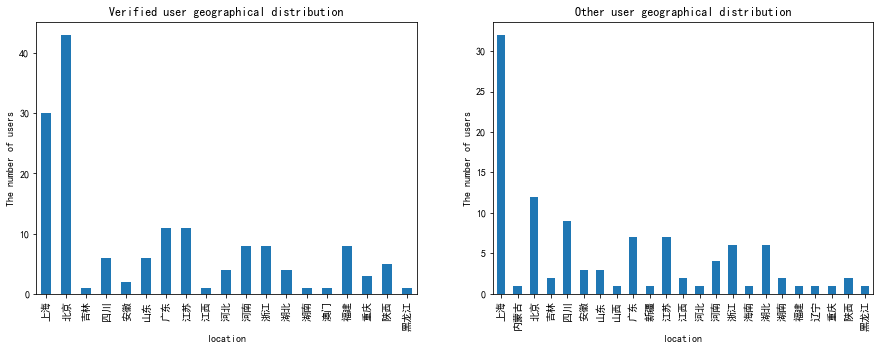

In [245]:
# Geographical Distribution of users（except 'overseas' and 'other')）
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
plt.ylabel('The number of users')
plt.title("Verified user geographical distribution")
user_frame[user_frame['verified']==True].groupby('location').size().drop(['海外','其他']).plot.bar()
ax2 = plt.subplot(1,2,2)
plt.ylabel('The number of users')
plt.title("Other user geographical distribution")
user_frame[user_frame['verified']!=True].groupby('location').size().drop(['海外','其他']).plot.bar()


# 3.Data cleansing and keyword extraction for Weibo

In [113]:
# Delete non-weibo text characters and extract keywords
def clean_text(raw):
    if raw['raw_text']:
        text=re.sub('<[^<]*>','',raw['raw_text'])  # Delete redundant html
        text=re.sub('[#\n]*','',text) # Delete line break and #
        text=re.sub('(http://.*)$','',text) # Delete url after the text
        return text 
    else:
        return None

# Obtain Chinese text of Weibo 
def get_chinese_text(raw):
    if raw['text']:
        res_text=''.join(re.findall(r"[\u4e00-\u9fff]{2,}",raw['text']))
        return (raw['mid'],res_text)
    else:
        return None

#Extract keywords 
def get_keywords(raw):
    if raw['chinese_text']:
        if raw['isLongText'] == 1:
            # When the text is long text, 50 keywords are extracted
            keywords = jieba.analyse.extract_tags(raw['chinese_text'],topK=50)
        else:
            # When the text is short text, 20 keywords are extracted
            keywords = jieba.analyse.extract_tags(raw['chinese_text'])
        return (raw['mid'],keywords)
    else:
        return None

def clean_created_date(raw):
    created_date = raw['created_at']
    if created_date.endswith('前'):
        created_date = '09-15'
    elif created_date.startswith('昨天'):
        created_date = '09-14'
    return created_date
# Get cleaned up created_date
mblog_frame['created_date'] = mblog_frame.apply(clean_created_date,axis=1)
# Get cleaned up text
mblog_frame['chinese_text'] = mblog_frame.apply(clean_text,axis=1)

# Generate DataFrame by incoming data into dictionary item()
res_mblog = pd.DataFrame(mblog_frame,columns=['mid','chinese_text','like_count','comments_count','reposts_count','created_date','user_id'])
# Write into CSV file to view the data cleansing results
res_mblog.to_csv('clean_mblog.csv', encoding='utf_8_sig',index=False)
# Get the keywords and convert to a decentralized DataFrame
mid_with_keyword = list(mblog_frame.apply(get_keywords,axis=1))
mid_with_keyword = list(filter(None, mid_with_keyword))# Cleaning invalid data
# To save keywords to database, we split the keywords to correspond to mid
keywords_list = [(raw[0],w) for raw in mid_with_keyword for w in raw[1]]
mid_with_keyword = pd.DataFrame(keywords_list,columns=['mid','keyword'])
# Write into CSV
mid_with_keyword.to_csv('keyword.csv', encoding='utf_8_sig',index=False)

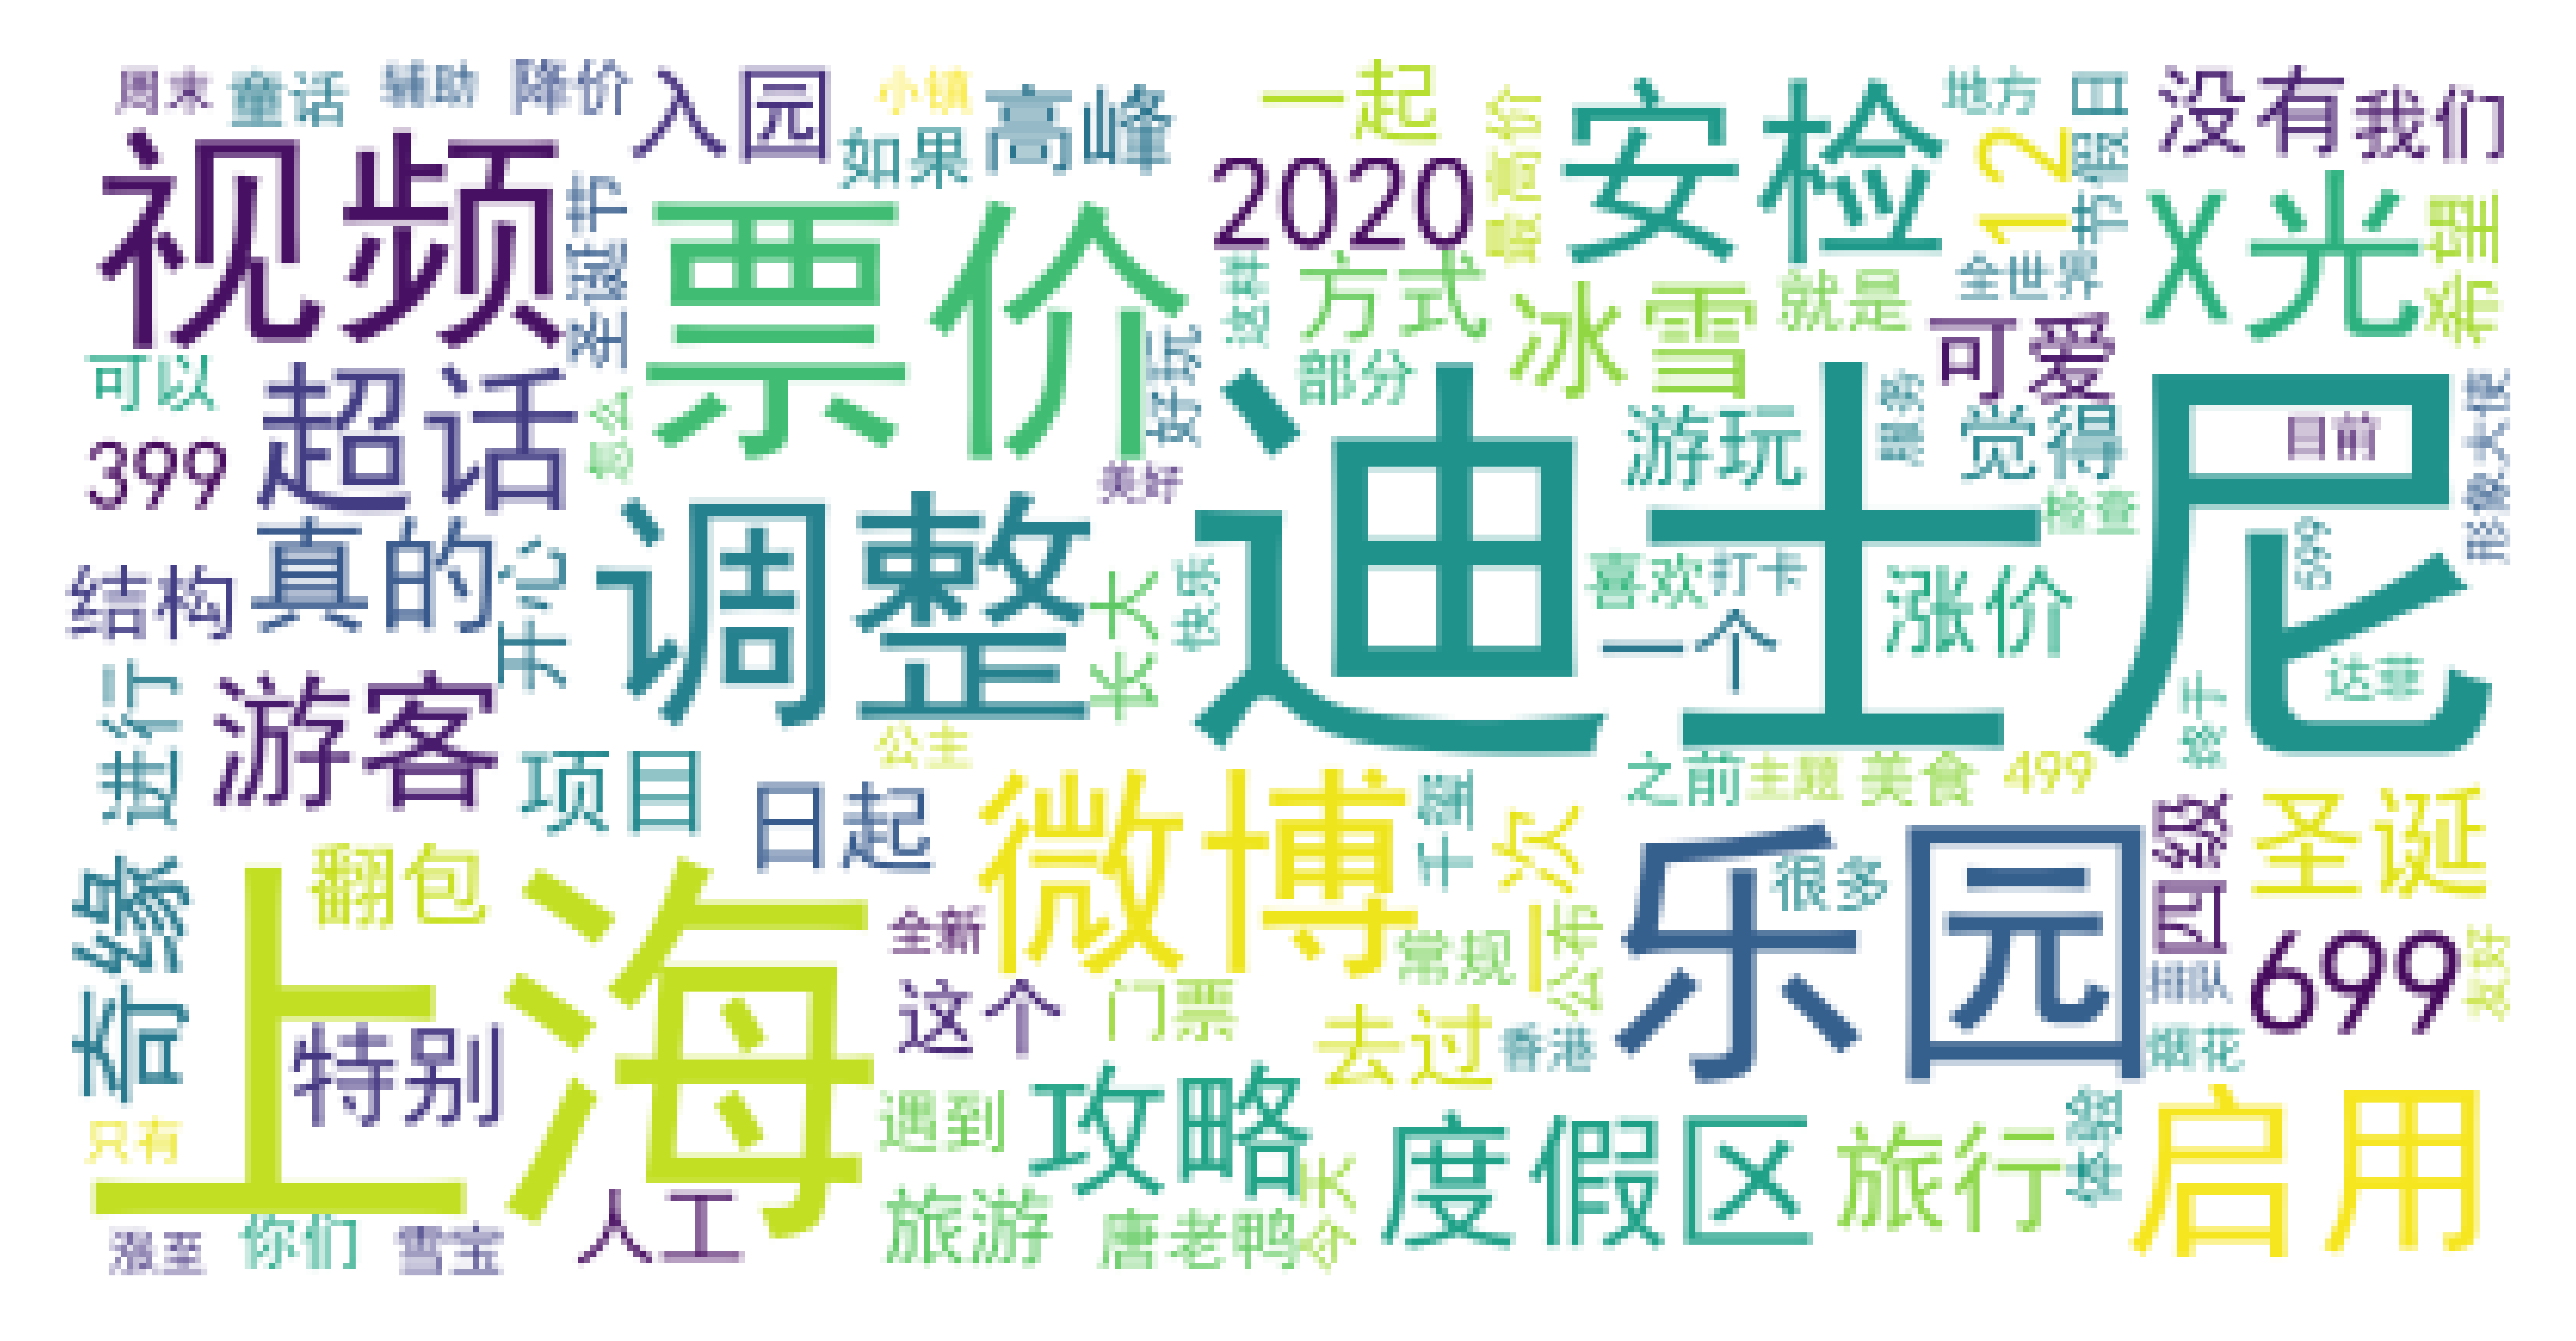

In [118]:
# Read Weibo data through database
keyword_frame = pd.read_csv('keyword.csv',index_col=False)
# Extract all keywords and make a list
all_keyword = list(keyword_frame.keyword)

# Use counter to collect the frequency of every keyword, then return to a dictionary, keyword:count
from collections import Counter
word_freq_frame = pd.DataFrame(Counter(all_keyword).items())
word_freq_frame.columns=['word','count']
top100_freq_word = word_freq_frame.sort_values('count',ascending=0).head(100)
top100_freq_word_dict=dict(list(top100_freq_word.apply(lambda w:(w['word'],w['count']),axis=1)))

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']# Display Chinese
plt.rcParams['axes.unicode_minus']=False # Display negative sign
%matplotlib inline
plt.rcParams['figure.dpi'] = 2000 # DPI
wc = WordCloud(background_color="white",max_words=2000,font_path='simhei.ttf')
wc.generate_from_frequencies(top100_freq_word_dict)
plt.imshow(wc)
plt.axis('off')
plt.show()


# 4.Training the model

In [3]:
# The attitude of training data was manually labeled in advance and read the training data 
# Positive attitude: 1, negative attitude: -1, neutrality: 0
mblog=pd.read_csv('clean_mblog.csv',encoding='utf_8_sig')
mblog=pd.DataFrame(mblog)
mblog.head()

,mid,chinese_text,like_count,comments_count,reposts_count,created_date,user_id,attitude
0,4.450000e+15,在上海迪士尼待了14个小时刷了13个项目的走心攻略！ 赶紧来马走～ 上海迪士尼调整票价 上海,822,62,413,9月15日,6118811663,1.0
1,4.450000e+15,【投票：上海迪士尼调整票价 你去过上海迪士尼乐园吗？】 财经网的微博投票,160354,365,219,9月15日,1642088277,0.0
2,4.450000e+15,王一博王一博上海迪士尼大雨中跳舞，王一博后劲太大了！我越来越爱他了咋办！！！ 律动poppi...,71,7,15,12月4日,6042105371,0.0
3,4.450000e+15,迪士尼玫玫缓缓倒下的画面，让无数拥有童心的人难受不已，这段视频在网络竟达到了近两亿的关注。迪...,26,9,3,9月15日,2100708653,-1.0
4,4.450000e+15,上海迪士尼调整票价 要是降价不是更多人了？？？平日票也没涨啊，香港迪士尼也不便宜呢吧，咋一个...,11,2,0,9月15日,3891544070,0.0


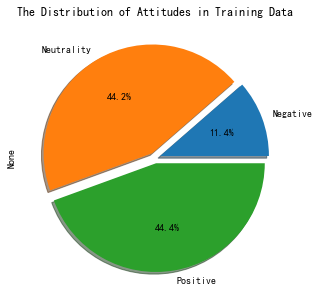

In [10]:
%matplotlib inline
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
labels = ['Negative','Neutrality','Positive']
plt.title('The Distribution of Attitudes in Training Data')
mblog.groupby('attitude').size().plot.pie(labels=labels,autopct='%1.1f%%',explode=(0.05,0.05,0.05),shadow=True)

The crawling data is classified by Weibo attitude, reflecting the recent attitude of Weibo users toward Shanghai Disneyland.

In [11]:
# Split keywords
def get_keywords2(word):
    keywords = jieba.analyse.extract_tags(word)
    keywords = '|'.join(keywords)
    return keywords
mblog['keywords']=[get_keywords2(str(word)) for word in mblog['chinese_text']]

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=2000,analyzer='word',tokenizer=lambda s:s.split('|'))
# Generate word vector
blog_bow = vectorizer.fit_transform(mblog['keywords'])
# Select training data
y = mblog[mblog['attitude'].notnull()]['attitude']
X=blog_bow[:len(y),:]
# Training model
lr_model = LogisticRegression(random_state=0,solver='lbfgs',multi_class='multinomial').fit(X,y)

# 5.Testing the model

In [248]:
# Import testing data
# The method to get testing data and the training data is the same
test=pd.read_csv('clean_mblog_test.csv',encoding='utf_8_sig')
test=pd.DataFrame(test)
test['keywords']=[get_keywords2(str(word)) for word in test['chinese_text']]
test_bow = vectorizer.transform(test['keywords'])
test.head()

,mid,chinese_text,like_count,comments_count,reposts_count,created_date,user_id,attitude,keywords
0,4.440000e+15,11月22日，冰雪奇缘2 将在内地院线上映。从2013年推出第一部《冰雪奇缘》到今天，它已经...,4,2,3,11月18日,1281021921,0,奇缘|迪士尼|冰雪|动画电影|11|22|2013|长片|续作|艾莎|剧透|前作|卖座|恢弘...
1,4.440000e+15,笨蛋去上海迪士尼 里天气最好（且没人）的一次了,12,11,4,11月18日,1788687065,1,笨蛋|迪士尼|没人|天气|最好|一次|上海
2,4.440000e+15,上海迪士尼迪士尼 全世界都在催我长大，只有迪士尼留住我最初对世界的希望💕 上海·上海迪士尼乐园,11,3,0,11月18日,2513856214,1,迪士尼|上海|留住|乐园|长大|全世界|最初|希望|世界|只有
3,4.440000e+15,上海日前有发现，安检人员依旧会对游客进行“搜包”检查，之前所称的X光机等设备并没有投入使用。...,824,2204,1407,11月18日,3307579552,-1,安检|乐园|搜包|X光|机等|via|logo|依旧会|上海|投入使用|所称|法律法规|迪士...
4,4.440000e+15,好漂酿！！！上海迪士尼超话,140,39,182,11月16日,1921547641,1,漂酿|超话|迪士尼|上海


The accuracy of the model is  0.5545454545454546


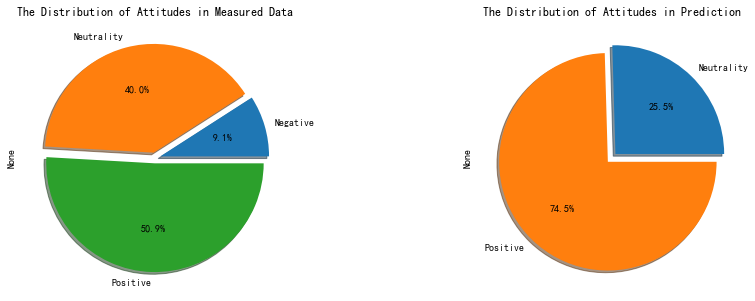

In [250]:
# Testing the model
%matplotlib inline
predict_attitude = pd.DataFrame(lr_model.predict(test_bow[:,:]),columns=['predict'])
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
labels = ['Negative','Neutrality','Positive']
plt.title('The Distribution of Attitudes in Measured Data')
test.groupby('attitude').size().plot.pie(labels=labels,autopct='%1.1f%%',explode=(0.05,0.05,0.05),shadow=True)
plt.subplot(1,2,2)
labels = ['Neutrality','Positive']
plt.title('The Distribution of Attitudes in Prediction')
predict_attitude.groupby('predict').size().plot.pie(labels=labels,autopct='%1.1f%%',explode=(0.05,0.05),shadow=True)

# Check test accuracy
y = test[test['attitude'].notnull()]['attitude']
X = test_bow[:len(y),:]
print('The accuracy of the model is ', lr_model.score(X,y))

There are two main reasons for the low accuracy of the model:
Firstly, the training data is not large enough, we need more data for training.
Secondly, the testing data was crawled after the training data in the search page, so the similarity of the key words itself is lower than the training data.